Estimated method: (701, [('B', 0, 5, 2), ('D', 4, 2, 4), ('E', 6, 3, 2), ('F', 6, 3, 1), ('G', 9, 4, 3), ('H', 13, 5, 2)])
estimated resourseList:  [5, 5, 5, 5, 9, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7]
early start:  B  es:  0
early start:  D  es:  3
early start:  E  es:  5
early start:  F  es:  5
early start:  G  es:  5
early start:  H  es:  9
estimated delay map:  {'A': 0, 'C': 0, 'I': 0, 'J': 0, 'K': 0, 'B': 0, 'D': 1, 'E': 1, 'F': 1, 'G': 4, 'H': 4}
val2:  ['A', 'C', 'I', 'J', 'K', 'B', 'D', 'E', 'F', 'G', 'H', 'R', 'R^2']
activity_index_map:  {'A': 0, 'C': 1, 'I': 2, 'J': 3, 'K': 4, 'B': 5, 'D': 6, 'E': 7, 'F': 8, 'G': 9, 'H': 10, 'R': 11, 'R^2': 12}


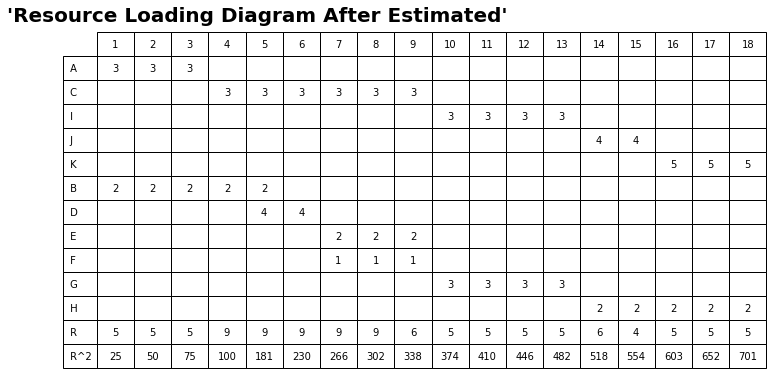

burgess result:  723
[3, 5, 5, 5, 9, 9, 6, 7, 7, 7, 7, 7, 7, 6, 6, 5, 5, 5]
H 10
G 6
F 7
E 10
D 4
B 1
Critical Path:  ['start', 'A', 'C', 'I', 'J', 'K', 'finish']
val2:  ['A', 'C', 'I', 'J', 'K', 'B', 'D', 'E', 'F', 'G', 'H', 'R', 'R^2']
activity_index_map:  {'A': 0, 'C': 1, 'I': 2, 'J': 3, 'K': 4, 'B': 5, 'D': 6, 'E': 7, 'F': 8, 'G': 9, 'H': 10, 'R': 11, 'R^2': 12}


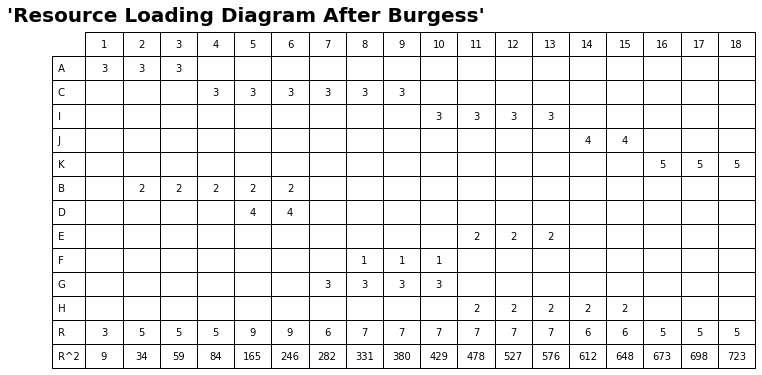

In [31]:
    ########## activity class ##################
    from operator import attrgetter
    import operator
    import copy
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    class Activity:
        def __init__(self, name, duration, resource, es, ef, ls, lf, totalfloat, pred, sucs,newStart, dependencyList, freefloat):
            self.name = name
            self.duration= int(duration)
            self.resource= int(resource)
            self.es=es
            self.ef=ef
            self.ls=ls
            self.lf=lf
            self.totalfloat=totalfloat
            self.pred=pred
            self.sucs=sucs
            self.newStart = newStart
            self.dependencyList = dependencyList
            self.freefloat=freefloat

    class inputProcessing:
        def __init__(self):
            super(inputProcessing, self).__init__()
            # self.arg = arg
            global start_activities
            global all_activity
            global filename
            global combinationList

        def takeinput(self):
            filename="data.txt"
            start_activities=[] #activities who don't have any predecessors
            all_activity=[] #list of all activity objects
            all_activity_node=[]
            combinationList=[]
            result=[]
            with open(filename) as f:
                activity_list = f.readlines()
            activity_list = [x.strip() for x in activity_list] 
            # print(activity_list)

            cnt=0
            for activity in activity_list:
                x=activity.split(",")
                # print(x)
                pred=[]
                pred_node_list=[]
                succ_node_list=[]
                sucs=[]
                ### assuming first column is name, last twos are resource and duration,, al others are dependency list
                for i in range(1,len(x)-2):
                    # print(x[i])
                    if x[i]=="-":
                        cnt+=1
                        start_activities.append(x[0])
                    pred.append(x[i])

                    # pred_node_list.append(x[i],x[len(x)-2],x[len(x)-1],-1,-1,9874217,9874217,-1,pred,sucs,-1))


                ac1=Activity(x[0],x[len(x)-2],x[len(x)-1],-1,-1,9874217,9874217,-1,pred,sucs,-1,[],-1)


                all_activity.append(ac1)
            ## if there are more than 1 start nodes, make a start node on your own
            if cnt>1:
                all_activity=inputProcessing().create_start_node(start_activities, all_activity)
            else:
                all_activity=inputProcessing().rename_start_node(start_activities, all_activity)

            # print(all_activity[0].name)
            all_activity=self.forward_pass(all_activity)
            # print("after fp ", all_activity)
            all_activity=self.backward_pass(all_activity)
            # print(all_activity)
            all_activity=self.get_dependency_list(all_activity)
            critical_path=self.get_critical_path(all_activity)
            
            resource_list=self.calculate_resource(all_activity)
            
            estimated_resource_list=[]
            for i in range(0,len(resource_list)):
                estimated_resource_list.append(resource_list[i])
            # print("resource_list ", resource_list)
            critical_path_resource_list=self.get_critical_path_resource_list(all_activity, critical_path)
            # print("initial_resource_list ", critical_path_resource_list)

            cumulative_r=self.calculate_cumulative_R(all_activity,resource_list)
            cumulative_r_2=self.calculate_cumulative_R_2(all_activity,resource_list)
            non_critical_path=self.get_non_critical_path(all_activity, critical_path)
            non_critical_nodes=self.get_non_critical_path_nodes(all_activity,non_critical_path)
            non_critical_activities=self.get_non_critical_activities(all_activity)
            sorted_non_critical_path_list=self.sort_non_critical_on_es(non_critical_path, all_activity)

            project_completion_time=self.get_project_completion_time(all_activity)

            ################ printing all the activities#####################
            # for activity in all_activity:
            # 	print("activity ", activity.name, activity.sucs, activity.pred, activity.es, activity.ef,  activity.ls,  activity.lf, activity.totalfloat, activity.freefloat)


            result=self.RecurcivelyValueFind([],sorted_non_critical_path_list,project_completion_time,0,[], result,combinationList)
            self.writeToListFile(result)
            deleteList=[]
            # print("get")
            resourseSquareList=[]
            ###################################################
            # print("combinationList ", len(combinationList))
            for i in range(0,len(combinationList)):
                elementList = combinationList[i]
                for j in range(0,len(elementList)):
                    getList = self.getAllDependentList(elementList[j][0],sorted_non_critical_path_list)
                    if(self.isValid(elementList,getList,elementList[j],i,deleteList)):
                        print()

            for i in range(0,len(deleteList)):
                combinationList[deleteList[i]]=None


            ##################################################################

            for i in range(0,len(combinationList)):
                if(combinationList[i]!=None):
                    elemnt = combinationList[i]
                    tempResourseList = copy.copy(critical_path_resource_list)
                    for j in range(0,len(elemnt)):
                        # print(int(elemnt[j][1]),int(elemnt[j][2]))
                        for k in range(int(elemnt[j][1]),(int(elemnt[j][1])+int(elemnt[j][2]))):
                            tempResourseList[k]+=int(elemnt[j][3])
                        # print(tempResourseList)
                    resourseSquareList.append((self.getResourseSquare(tempResourseList),combinationList[i]))
                    del tempResourseList

            ###############################################################

            EstimatedMethod = []
            minimum=99999999
            for i in range(len(resourseSquareList)):
                if (resourseSquareList[i][0] < minimum):
                    minimum = resourseSquareList[i][0]
                    EstimatedMethod = resourseSquareList[i]

            print("Estimated method:", EstimatedMethod)
            
            copy_critical_path_resource_list=[]
            for i in range(0,len(critical_path_resource_list)):
                copy_critical_path_resource_list.append(critical_path_resource_list[i])
                
            #print("resource list:",resource_list)
            #estimated_resource_list=copy.deepcopy(resource_list)
            for i in range(len(EstimatedMethod[1])):
                for j in range(0,int(EstimatedMethod[1][i][2])):
                    #print(EstimatedMethod[1][i][0],EstimatedMethod[1][i][3],j)
                    copy_critical_path_resource_list[EstimatedMethod[1][i][1]+j]+=EstimatedMethod[1][i][3]
            print("estimated resourseList: ",copy_critical_path_resource_list)
            
            estimated_r_2 = self.calculate_cumulative_R_2(all_activity, copy_critical_path_resource_list)
            #for i in range(0, len(sorted_non_critical_path_list)):
                #print(sorted_non_critical_path_list[i].name, sorted_non_critical_path_list[i].newStart)
            
            #print("Saaj: ",EstimatedMethod[1][5][1])
            
            val2=[]
            #print("Critical Path: ",critical_path)
            delay_map={}
            for i in range(1,len(critical_path)-1):
                delay_map[critical_path[i]]=0
                val2.append(critical_path[i])
            
            #j=len(sorted_non_critical_path_list)-1
            for i in range(0, len(sorted_non_critical_path_list)):
                for k in range(0,len(EstimatedMethod[1])):
                    if EstimatedMethod[1][k][0]==sorted_non_critical_path_list[i].name:
                        print("early start: ",sorted_non_critical_path_list[i].name," es: ",sorted_non_critical_path_list[i].es)
                        delay=int(EstimatedMethod[1][k][1])-int(sorted_non_critical_path_list[i].es)
                        delay_map[sorted_non_critical_path_list[i].name]=delay
                        val2.append(sorted_non_critical_path_list[i].name)
                        #j=j-1
            
            print("estimated delay map: ",delay_map)
            title_estimated="'Resource Loading Diagram After Estimated'"
            self.create_diagram(title_estimated, val2,delay_map,non_critical_activities, all_activity, resource_list, estimated_r_2, critical_path)

            ###################################################
            with open('combinationList2.txt', 'w') as filehandle:
                for i in range(len(combinationList)):
                    if(combinationList[i]!=None):
                        filehandle.write(str(combinationList[i]))
                        filehandle.write(str('\n'))

            with open('deleteList.txt', 'w') as filehandle:
                for i in range(len(deleteList)):
                    filehandle.write(str(deleteList[i]))
                    filehandle.write(str('\n'))

            with open('square.txt', 'w') as filehandle:
                for i in range(len(resourseSquareList)):
                    filehandle.write(str(resourseSquareList[i]))
                    filehandle.write(str('\n'))

            ########################################################
            tupleNodeList = []

            for i in range(0, len(non_critical_nodes)):
                tupleNodeList.append((non_critical_nodes[i].ef, non_critical_nodes[i].name))
            tupleNodeList = sorted(tupleNodeList, key=lambda x: x[1])
            sortedNodeList = []

            for i in reversed(range(len(tupleNodeList))):
                for j in range(len(non_critical_nodes)):
                    if (non_critical_nodes[j].name == tupleNodeList[i][1]):
                        sortedNodeList.append(non_critical_nodes[j])
            self.get_burgess_value(sortedNodeList, resource_list, non_critical_activities, all_activity, critical_path)
        def get_non_critical_path_nodes(self, all_activity,non_critical_path):
            non_critical_nodes=[]
            for activity in all_activity:
                if activity.name in non_critical_path:
                    non_critical_nodes.append(activity)

            # for activity in non_critical_nodes:
            # 	print(activity.name)
            return non_critical_nodes
        
        def get_non_critical_activities(self, all_activity):
            non_critical_activities=[]
            for activity in all_activity:
                if activity.freefloat!=0:
                    non_critical_activities.append(activity)
            
            #print("non-critical: ",activity.name)
            return non_critical_activities

        def changePredecessor(self,node: Activity, sortedNodeList):
            for i in range(0, len(sortedNodeList)):
                for j in range(0, len(sortedNodeList[i].sucs)):
                    if (sortedNodeList[i].dependencyList[j].name == node.name):
                        sortedNodeList[i].freefloat += 1
                        # print(sortedNodeList[i].NodeName,sortedNodeList[i].FreeFloat)
                        continue

        def get_burgess_value(self,sortedNodeList, resource_list, non_critical_activities, all_activity, critical_path):

            burgessResult = 0
            for i in range(len(sortedNodeList)):
                node = sortedNodeList[i]
                sumOfSquare = 9999999999
                iteration = -1
                # print(node.NodeName)
                tempResourse = copy.copy(resource_list)
                minimunRecourseList = []
                for i in range(0, node.freefloat):
                    tempResourse[node.ef + i] += node.resource
                    tempResourse[node.es + i] -= node.resource
                    if sumOfSquare > self.getResourseSquare(tempResourseList=tempResourse):
                        sumOfSquare = self.getResourseSquare(tempResourseList=tempResourse)
                        iteration = i + 1
                        minimunRecourseList = copy.copy(tempResourse)

                        # print(sumOfSquare,i+1,minimunRecourseList)

                resource_list = minimunRecourseList
                node.newStart = node.es + iteration
                self.changePredecessor(node,sortedNodeList)
                burgessResult = sumOfSquare

            print("burgess result: ",burgessResult)
            print(resource_list)
            burgess_r_2 = self.calculate_cumulative_R_2(all_activity, resource_list)
            for i in range(0, len(sortedNodeList)):
                print(sortedNodeList[i].name, sortedNodeList[i].newStart)
            
            val2=[]
            print("Critical Path: ",critical_path)
            delay_map={}
            for i in range(1,len(critical_path)-1):
                delay_map[critical_path[i]]=0
                val2.append(critical_path[i])
            j=len(sortedNodeList)-1
            for i in range(0, len(sortedNodeList)):
                delay=sortedNodeList[i].newStart-sortedNodeList[i].es
                delay_map[sortedNodeList[i].name]=delay
                val2.append(sortedNodeList[j].name)
                j=j-1
            
            
            title_burgess="'Resource Loading Diagram After Burgess'"
            self.create_diagram(title_burgess,val2,delay_map,non_critical_activities, all_activity, resource_list, burgess_r_2, critical_path)
            
        def create_diagram(self, title,val2,delay_map, non_critical_activities, all_activity, resource_list, cumulative_r_2, critical_path):
        #print("non_critical_activities, all_activity, resource_list, cumulative_r, cumulative_r_2, critical_path")
        #print(non_critical_activities, all_activity, resource_list, cumulative_r, cumulative_r_2, critical_path)
            val1=[]
            #val2=["A","C","I","J","K","B","G","H","D","E","F","R","R^2"]
            val2.append("R")
            val2.append("R^2")
            print("val2: ",val2)
            row_header=[]
            for i in range(0,len(val2)):
                row_header.append(" "+val2[i]+" ")

            #need to make generic
            for activity in all_activity:
                if activity.name=="finish":
                    days=activity.es
            for i in range(1,days+1):
                val1.append(i)
            val3 = [["" for c in range(1,days+1)] for r in range(1,len(val2)+1)]

            rowColours=[]
            colColours=[]
            cellColours=[]

            activity_index_map={}
            for i in range (0,len(val2)):
                activity_index_map[val2[i]]=i

            print("activity_index_map: ", activity_index_map)

            #need to make generic 
            rows, cols = (len(val2), days) 
            #table = [[0]*cols]*rows
            table = [["" for c in range(0,cols)] for r in range(0,rows)]
     

            #print(table)
            colWidths=[]
            for i in range(0,cols):
                colWidths.append((1/cols)*2)

            
            #val3 = [["" for c in range(1,19)] for r in range(1,14)]
            table2 = [["" for c in range(0,cols)] for r in range(0,rows)]

            for r in range (0,rows-2):
                for key in activity_index_map:
                    if activity_index_map[key]==r:
                        activity_name=key
                for activity in all_activity:
                    if activity.name==activity_name:
                        current_resource=activity.resource
                        current_es=activity.es+delay_map[activity_name]
                        current_ef=activity.ef+delay_map[activity_name]

                for c in range (0,cols):
                    if c>=current_es and c<current_ef:#if c is between es and ef range
                        table2[r][c]= current_resource #
                        val3[r][c]= current_resource #resource

            for c in range (0,cols):
                table2[r+1][c]= resource_list[c] #updated resource list
                val3[r+1][c]= resource_list[c] #updated resource list
                table2[r+2][c]= cumulative_r_2[c] #updated cululative r^2
                val3[r+2][c]= cumulative_r_2[c] #updated cululative r^2

            #print(table2)

            fig, ax = plt.subplots() 
            ax.set_axis_off() 
            table = ax.table( 
                cellText = val3,  
                rowLabels = row_header,  
                colLabels = val1, 
                rowColours =["white"] * rows,  
                colColours =["white"] * cols, 
                cellLoc ='center', 
                colWidths = colWidths,
                loc ='upper left') 

            table.set_fontsize(10)
            table.scale(1, 2)

            ax.set_title(title, 
                 fontweight ="bold", fontsize=20) 

            plt.show()


        def get_project_completion_time(self,all_activity):
            project_completion_time=0
            for activity in all_activity:
                if activity.sucs==[]:
                    project_completion_time=activity.lf

            return project_completion_time

        def get_critical_path_resource_list(self,all_activity, critical_path):
            n=all_activity[len(all_activity)-1].lf
            # print("finish ",n)
            critical_path_resource_list=[0]*n
            i=0
            for activity in all_activity:
                # print(activity.resource)
                if activity.name in critical_path:
                    for x in range(activity.es, activity.ef):
                        critical_path_resource_list[x]=critical_path_resource_list[x]+activity.resource

            # print(critical_path_resource_list)
            return critical_path_resource_list

        def rename_start_node(self, start_activities, all_activity):
            sucs_list=[]
            all_activity=self.get_successor_list(all_activity)
            for activity in all_activity:
                if activity.name==start_activities[0]:
                    activity.name="start"
                    activity.es=0
                    activity.ef=activity.es+activity.duration
                    sucs_list=activity.sucs
            # print("sucs ", sucs_list)
            for activity in all_activity:
                if activity.name in sucs_list:
                    activity.pred=["start"]

            return all_activity


        def create_start_node(self, start_activities, all_activity):
            pred=[]
            sucs=start_activities
            ac1=Activity("start",0,0,0,0,0,0,0,pred,sucs,-1,[],-1)
            # all_activity.append(ac1)
            all_activity.insert(0,ac1)
            ## inserting start node at the 0 position
            # print(all_activity[0].sucs)
            return all_activity

        def create_finish_node(self, finish_activities, all_activity):
            pred=finish_activities
            sucs=[]
            ac1=Activity("finish",0,0,-1,-1,-1,-1,-1,finish_activities,sucs,-1,[],-1)
            all_activity.append(ac1)

            return all_activity

        def bfs_forward_pass(self,visited,queue, graph, node, all_activity):
            visited.append(node)
            queue.append(node)
            # print(graph)
            ## dictionary for mapping the activity names with the activity objects easily
            activity_dict={}
            for activity in all_activity:
                activity_dict[activity.name]=activity
                # print(activity.name)


            while queue:
                s = queue.pop(0) 
                # print ("lol ",s, end = " ") 
                # print(graph)
                for neighbour in graph[s]:
                    #### visiting each neighbour and calculating ES and EF
                    activity_dict[neighbour].es=max(activity_dict[s].ef,activity_dict[neighbour].es)
                    activity_dict[neighbour].ef=activity_dict[neighbour].es+activity_dict[neighbour].duration
                    # print("neighbour ",neighbour, activity_dict[neighbour].es)
                    if neighbour not in visited:
                        visited.append(neighbour)
                        queue.append(neighbour)
            #### we were keeping values in the dict before, nnow keepingthis in the main list
            for activity in all_activity:
                activity.es=activity_dict[activity.name].es
                activity.ef=activity_dict[activity.name].ef
            # print(all_activity)

            return all_activity

        def bfs_backward_pass(self,visited,queue, graph, node, all_activity):
            visited.append(node)
            queue.append(node)
            # print(graph)
            ## dictionary for mapping the activity names with the activity objects easily
            activity_dict={}
            for activity in all_activity:
                activity_dict[activity.name]=activity
                # print(activity.name)


            while queue:
                s = queue.pop(0) 
                # print ("lol ",s, end = " ") 
                # print(graph)
                for neighbour in graph[s]:
                    if neighbour!="-":
                        #### visiting each neighbour and calculating LS and LF
                        ############ parallel path gular level equivalent na hole jhamela---------
                        activity_dict[neighbour].lf=min(activity_dict[s].ls,activity_dict[neighbour].lf)
                        activity_dict[neighbour].ls=activity_dict[neighbour].lf-activity_dict[neighbour].duration
                        # print("neighbour ",neighbour, activity_dict[neighbour].lf)
                        if neighbour not in visited:
                            visited.append(neighbour)
                            queue.append(neighbour)
            #### we were keeping values in the dict before, nnow keepingthis in the main list
            for activity in all_activity:
                activity.ls=activity_dict[activity.name].ls
                activity.lf=activity_dict[activity.name].lf
            # return all_activity
            # print("sghHDFGDFS",all_activity[0].name)

            return all_activity
        def get_successor_list(self, all_activity):
            pred_dict={}
            for activity in all_activity:
                pred_dict[activity.name]=activity.pred

            for activity in all_activity:
                sucs_list=[]
                for key in pred_dict:
                    # print(pred_dict[key])
                    if activity.name in pred_dict[key]:
                        sucs_list.append(key)
                        # sucs_dict[activity.name]=key
                # sucs_dict[activity.name]=sucs_list
                activity.sucs=sucs_list
            return all_activity
        def forward_pass(self,all_activity):
            # all_activity
            ############ mapping activities with predecessors#####################
            pred_dict={}
            for activity in all_activity:
                pred_dict[activity.name]=activity.pred


            start_sucs=[] #keeps the valaues  of the successors of start node

            ##### inserting start as start node of the nodes, who do not have any predecessors
            for key in pred_dict:
                if pred_dict[key]==['-'] and key!="start":
                    # print("key ", key, pred_dict[key])
                    pred_dict[key]="start"
                    start_sucs.append(key)
            for activity in all_activity:
                if activity.name=="start":
                    activity.sucs=start_sucs
            for activity in all_activity:
                for val in start_sucs:
                    if activity.name==val:
                        activity.pred=['start']

            sucs_dict={}### mapping each node with it's successors list
            cnt=0
            finish_activities=[]### the activities who do nont have any successors

            ##### checking if a key is in the predecessors list of a node, if true,   
            ######### the key is the successor of the predecessors
            for activity in all_activity:
                sucs_list=[]
                for key in pred_dict:
                    # print(pred_dict[key])
                    if activity.name in pred_dict[key]:
                        sucs_list.append(key)
                        # sucs_dict[activity.name]=key
                sucs_dict[activity.name]=sucs_list
                activity.sucs=sucs_list
                if sucs_list==[] and activity.name!="start":
                    cnt+=1
                    finish_activities.append(activity.name)
            if cnt>1:
                ### if thereis morethan one finish node, then create a finish node
                all_activity=inputProcessing().create_finish_node(finish_activities,all_activity)

            # print(all_activity[len(all_activity)-1].pred)


            visited = [] # List to keep track of visited nodes.
            queue = []     #Initialize a queue

            ############# calling cfs with start node###############
            all_activity=inputProcessing().bfs_forward_pass(visited, queue, sucs_dict, 'start', all_activity)



            ### putting the activities who do not have any successor, as successor of finish activities
            all_activity[len(all_activity)-1].pred=finish_activities 
            for activity in all_activity:
                for val in finish_activities:
                    if activity.name==val:
                        activity.sucs=['finish']
                        ### calculating value of finish nodes
                        all_activity[len(all_activity)-1].es=max(all_activity[len(all_activity)-1].es,activity.ef)
                        all_activity[len(all_activity)-1].ef=all_activity[len(all_activity)-1].es


            ################ printing all the activities#####################
            # for activity in all_activity:
            # 	print("activity ", activity.name, activity.sucs, activity.pred, activity.es, activity.ef)
            return all_activity


        def backward_pass(self, all_activity):
            pred_dict={}
            for activity in all_activity:
                pred_dict[activity.name]=activity.pred
                if activity.name=="finish":
                    activity.lf=activity.ef
                    activity.ls=activity.lf
            # print(pred_dict)
            visited = [] # List to keep track of visited nodes.
            queue = []     #Initialize a queue

            ############# calling bfs with start node###############
            all_activity=inputProcessing().bfs_backward_pass(visited, queue, pred_dict, 'finish', all_activity)

            ################ printing all the activities#####################
            # for activity in all_activity:
            # 	print("activity ", activity.name, activity.sucs, activity.pred, activity.es, activity.ef,  activity.ls,  activity.lf)

            # print(all_activity[0].name)
            return all_activity

        def get_critical_path(self, all_activity):
            critical_path=[]
            # print(all_activity)
            for activity in all_activity:
                if activity.ls-activity.es==0:
                    activity.totalfloat=0
                    activity.freefloat=0
                    critical_path.append(activity.name)
                else:
                    activity.totalfloat= activity.ls-activity.es
                    min_es_of_successor=self.get_min_es_of_successor(all_activity, activity)
                    activity.freefloat= min_es_of_successor-activity.ef

            # print(critical_path)
            return critical_path

        def get_min_es_of_successor(self, all_activity, activity):
            temp_es=99999
            for pr in activity.sucs:
                # print("Pr: ",pr)
                for ac in all_activity:
                    if ac.name==pr:
                        if ac.es<temp_es:
                            temp_es=ac.es

            return temp_es

        def calculate_resource(self,all_activity):
            n=all_activity[len(all_activity)-1].lf
            # print("finish ",n)
            resource_list=[0]*n
            i=0
            for activity in all_activity:
                # print(activity.resource)
                for x in range(activity.es, activity.ef):
                    resource_list[x]=resource_list[x]+activity.resource

            # print(resource_list)
            return resource_list
        def calculate_cumulative_R(self,all_activity, resource_list):
            n=all_activity[len(all_activity)-1].lf
            cumulative_r=[0]*n
            cumulative_r[0]=resource_list[0]
            i=1
            for res in range(1,len(resource_list)):
                cumulative_r[i]=cumulative_r[i-1]+resource_list[res]
                i+=1

            # print(cumulative_r)

            return cumulative_r
        def calculate_cumulative_R_2(self,all_activity, resource_list):
            n=all_activity[len(all_activity)-1].lf
            cumulative_r_2=[0]*n
            cumulative_r_2[0]=resource_list[0]**2
            i=1
            for res in range(1,len(resource_list)):
                cumulative_r_2[i]=cumulative_r_2[i-1]+resource_list[res]**2
                i+=1

            # print(cumulative_r_2)
            return cumulative_r_2

        def get_non_critical_path(self,all_activity,critical_path):
            non_critical_path=[]
            # print(critical_path)
            for activity in all_activity:
                if activity.name not in critical_path:
                    non_critical_path.append(activity.name)



            return non_critical_path

        def sort_non_critical_on_es(self, non_critical_path, all_activity):
            sorted_non_critical_path_list=[]
            for activity in all_activity:
                if activity.name in non_critical_path:
                    sorted_non_critical_path_list.append(activity)
            sorted_non_critical_path_list=sorted(sorted_non_critical_path_list, key=operator.attrgetter('es'))

            # for val in sorted_non_critical_path_list:
                # print("print",val.name)

            return sorted_non_critical_path_list

        def get_dependency_list(self,all_activity):


            for activity in all_activity:
                for suc_val in activity.sucs:
                    # print("suc", suc_val, activity.name)
                    for suc_activity in all_activity:
                        if suc_activity.name==suc_val:
                            # print("n", suc_activity.name, suc_val)
                            activity.dependencyList.append(suc_activity)

            # for activity in all_activity:
            # 	print("activity ", activity.name, activity.sucs, activity.pred, activity.es, activity.ef,  activity.ls,  activity.lf)
            # 	for val in activity.dependencyList:
            # 		print(val.name)

            return all_activity
        def writeToListFile(self,result):
            with open('listfile.txt', 'w') as filehandle:
                for i in range(len(result)):
                    filehandle.write(str(result[i]))
                    filehandle.write(str('\n'))

        def RecurcivelyValueFind(self,ExistingDefinedNodeList: [], RemainList: [], TimeDuration, iteration, nodeList: [],result,combinationList):
            if (iteration == len(RemainList)):
                return
            else:
                for j in range(0, RemainList[iteration].totalfloat + 1):
                    if RemainList[iteration].totalfloat > -1:
                        iteration = copy.copy(iteration)
                        nodeList = copy.deepcopy(nodeList)
                        RemainList = copy.deepcopy(RemainList)
                        RemainList[iteration].totalfloat -= 1
                        RemainList[iteration].Start = RemainList[iteration].es+j


                        for index in range(len(nodeList)):
                            if nodeList[index][0]==RemainList[iteration].name:
                                nodeList.pop(index)

                        if((RemainList[iteration].Start+RemainList[iteration].duration)<=RemainList[iteration].lf and (RemainList[iteration].Start+RemainList[iteration].duration)<=TimeDuration):
                            nodeList.append((RemainList[iteration].name, RemainList[iteration].Start,RemainList[iteration].duration,RemainList[iteration].resource))
                        if(iteration==(len(RemainList)-1)):
                            combinationList.append(nodeList)
                        result.append((RemainList[iteration].name, j))
                        #print(RemainList[iteration].NodeName, j, iteration)
                        ExistingDefinedNodeList.append(RemainList[iteration])
                        if (iteration==5):
                            self.RecurcivelyValueFind(ExistingDefinedNodeList, RemainList, TimeDuration, iteration + 1, [], result,combinationList)
                        else :
                            self.RecurcivelyValueFind(ExistingDefinedNodeList, RemainList, TimeDuration, iteration + 1, nodeList,result,combinationList)

            return result


            # Total_list=[node_B,node_D,node_F,node_E,node_G,node_H]

        def getAllDependentList(self,Name:'',sorted_non_critical_path_list):
            for i in range(0,len(sorted_non_critical_path_list)):
                if(Name==sorted_non_critical_path_list[i].name):
                    return sorted_non_critical_path_list[i].dependencyList




        def isValid(self,elementList:[],childList:[],compareNode,index,deleteList):
            for i in range(0,len(elementList)):
                for j in range(0,len(childList)):
                    if(childList[j].name==elementList[i][0] and compareNode[1]+compareNode[2]>elementList[i][1]):
                        #print(elementList)
                        deleteList.append(index)


        def getResourseSquare(self,tempResourseList:[]):
            square=0
            for i in range(0,len(tempResourseList)):
                square+=np.square(tempResourseList[i])
            # print("square ", square, len(tempResourseList))
            return  square


    inputProcessing().takeinput()
    # inputProcessing().forward_pass()